In [2]:
import pandas as pd
# covid_data — данные о показателях заболеваемости за каждый день в различных регионах 187 стран. 
covid_data = pd.read_csv('data/covid_data.csv')
display(covid_data.head())

,date,province/state,country,confirmed,deaths,recovered
0,01/22/2020,Anhui,China,1.0,0.0,0.0
1,01/22/2020,Beijing,China,14.0,0.0,0.0
2,01/22/2020,Chongqing,China,6.0,0.0,0.0
3,01/22/2020,Fujian,China,1.0,0.0,0.0
4,01/22/2020,Gansu,China,0.0,0.0,0.0


## Мы будем работать со следующими столбцами:

- date — дата наблюдения;
- province/state — наименование провинции/штата;
- country — наименование страны;
- confirmed — общее число зафиксированных случаев на указанный день;
- deaths — общее число зафиксированных смертей на указанный день;
- recovered — общее число выздоровлений на указанный день.

In [3]:
# country_vaccinations — данные о процессе вакцинирования людей в 221 стране мира.

# Обратите внимание, что в приведённом источнике https://www.kaggle.com/gpreda/covid-world-vaccination-progress данные о вакцинации постоянно обновляются. В данном модуле будет использоваться файл, который мы скачали заранее.

vaccinations_data = pd.read_csv('data/country_vaccinations.csv')
vaccinations_data = vaccinations_data[
    ['country', 'date', 'total_vaccinations', 
     'people_vaccinated', 'people_vaccinated_per_hundred',
     'people_fully_vaccinated', 'people_fully_vaccinated_per_hundred',
     'daily_vaccinations', 'vaccines']
]

## Данная таблица содержит следующие столбцы:

- country — наименование страны;
- date — дата наблюдения;
- total_vaccinations — общее число введённых вакцин в стране на указанный день;
- people_vaccinated — общее число привитых первым компонентом в стране на указанный день;
- people_vaccinated_per_hundred — процент привитых первым компонентом в стране на указанный день (рассчитывается как );
- people_fully_vaccinated — общее число привитых вторым компонентом в стране на указанный день (первый компонент уже был введён им ранее);
- people_fully_vaccinated_per_hundred — процент привитых вторым компонентом в стране на указанный день (рассчитывается как );
- daily_vaccination — ежедневная вакцинация (число вакцинированных в указанный день);
- vaccines — комбинации вакцин, используемые в стране.

В данных много пропусков, а также неверно введённых значений. Например, для США (United States) и Великобритании (United Kingdom) в большинстве записей таблицы covid_data число выздоровевших людей равно 0. В данном модуле мы закроем на это глаза, но вообще эти страны подлежали бы исключению из данных или нам понадобился бы дополнительный источник данных, из которого мы смогли бы получить недостающую информацию.

Обратите внимание, что признаки confirmed, deaths, recovered, total_vaccination, people_vaccinated, people_fully_vaccinated — это суммарные показатели по стране, то есть с каждым днём они должны расти. Такие признаки называют накопительными.

Возникает большое желание объединить таблицы. Для этого необходимо учитывать следующие нюансы:

1. В таблице covid_data необходимо предварительно рассчитать суммарное ежедневное число заболевших во всех провинциях/штатах в каждой стране.
2. В таблицах не совпадает число стран, а иногда и их названия. 
При объединении таблиц по столбцу мы определённо теряем данные (в данной задаче потери незначительны). Избежать этого можно ручными преобразованиями данных — искать различия в названиях стран в таблицах и преобразовывать их. Однако это не является темой данного модуля.

3.Таблицы имеют разные периоды наблюдений (вакцины появились позже, чем сам вирус). Объединив данные с типом inner, мы можем потерять большое количество наблюдений в таблице covid_data.

## ПРЕДОБРАБОТКА ДАННЫХ

Опираясь на замечания выше, выполним небольшую предобработку.

В таблице covid_data:

1. Группируем таблицу по дате и названию страны и рассчитываем суммарные показатели по всем регионам. Тем самым переходим от данных по регионам к данным по странам:

In [4]:
covid_data = covid_data.groupby(
    ['date', 'country'],
    as_index=False
)[['confirmed', 'deaths', 'recovered']].sum()
covid_data

,date,country,confirmed,deaths,recovered
0,01/01/2021,Afghanistan,51526.0,2191.0,41727.0
1,01/01/2021,Albania,58316.0,1181.0,33634.0
2,01/01/2021,Algeria,99897.0,2762.0,67395.0
3,01/01/2021,Andorra,8117.0,84.0,7463.0
4,01/01/2021,Angola,17568.0,405.0,11146.0
...,...,...,...,...,...
86780,12/31/2020,Vietnam,1465.0,35.0,1325.0
86781,12/31/2020,West Bank and Gaza,138004.0,1400.0,117183.0
86782,12/31/2020,Yemen,2099.0,610.0,1394.0
86783,12/31/2020,Zambia,20725.0,388.0,18660.0


2. Преобразуем даты в формат datetime с помощью функции pd.to_datetime():

In [5]:
covid_data['date'] = pd.to_datetime(covid_data['date'])

3. Создадим признак больных на данный момент (active). Для этого вычтем из общего числа зафиксированных случаев число смертей и число выздоровевших пациентов:

In [6]:
covid_data['active'] = covid_data['confirmed'] - covid_data['deaths'] - covid_data['recovered']

4. Создадим признак ежедневного прироста числа заболевших, умерших и выздоровевших людей. Для этого отсортируем данные по названиям стран, а затем по датам. После этого произведём группировку по странам и рассчитаем разницу между «вчера и сегодня» с помощью метода diff():

In [7]:
covid_data = covid_data.sort_values(by=['country', 'date'])
covid_data['daily_confirmed'] = covid_data.groupby('country')['confirmed'].diff()
covid_data['daily_deaths'] = covid_data.groupby('country')['deaths'].diff()
covid_data['daily_recovered'] = covid_data.groupby('country')['recovered'].diff()
display(covid_data)

,date,country,confirmed,deaths,recovered,active,daily_confirmed,daily_deaths,daily_recovered
11337,2020-02-24,Afghanistan,1.0,0.0,0.0,1.0,NaN,NaN,NaN
11570,2020-02-25,Afghanistan,1.0,0.0,0.0,1.0,0.0,0.0,0.0
11807,2020-02-26,Afghanistan,1.0,0.0,0.0,1.0,0.0,0.0,0.0
12051,2020-02-27,Afghanistan,1.0,0.0,0.0,1.0,0.0,0.0,0.0
12299,2020-02-28,Afghanistan,1.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
15933,2020-03-12,occupied Palestinian territory,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16595,2020-03-14,occupied Palestinian territory,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16938,2020-03-15,occupied Palestinian territory,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17290,2020-03-16,occupied Palestinian territory,0.0,0.0,0.0,0.0,0.0,0.0,0.0


В таблице vaccinations_data достаточно будет преобразовать столбцы в формат datetime:

In [8]:
vaccinations_data['date'] = pd.to_datetime(vaccinations_data['date'])

### Задание 3.1
За какой период представлены данные в таблице covid_data? В качестве ответа введите даты в формате datetime (без указания времени).
Введите ответ в следующем формате (без пробелов): ГГГГ-ММ-ДД-ГГГГ-ММ-ДД

In [9]:
min_date = covid_data['date'].min().date()
max_date = covid_data['date'].max().date()
print(f'{min_date}-{max_date}')
# print(covid_data['date'].min().date(),'-',covid_data['date'].max().date())
# covid_data['date'].date.max()
# print(covid_data['date'].max())

2020-01-22-2021-05-29


### Задание 3.2
За какой период представлены данные в таблице vaccinations_data? В качестве ответа введите даты в формате datetime без указания времени.
Введите ответ через дефис (например, 2020-01-01-2021-01-01).

In [11]:
print(f"{vaccinations_data['date'].min().date()}-{vaccinations_data['date'].max().date()}")


2020-12-02-2021-09-06


### Задание 3.3
С помощью метода merge() объедините таблицы covid_data и vaccinations_data по столбцам date и country.
Тип объединения выставьте так, чтобы в результирующую таблицу попали только наблюдения за период, вычисленный в задании 3.1. То есть в результирующую таблицу должны попасть все записи из таблицы covid_data и из её пересечения с vaccinations_data, но не более. Результат объединения занесите в переменную covid_df.
Сохраните таблицу covid_df — она понадобится нам в следующем юните.

Сколько строк и столбцов в таблице covid_df?
Введите ответ в виде двух чисел через дефис (например, 333-33): первое число — количество строк, второе число — количество столбцов.

In [14]:
covid_df = covid_data.merge(
    vaccinations_data,
    on=['date', 'country'],
    how='left'    
)
display(covid_df.shape)

(86785, 16)

В получившейся в задании 3.3 таблице covid_df создайте признаки death_rate — общий процент смертей среди зафиксированных случаев (летальность) и recover_rate — общий процент случаев выздоровления. Данные характеристики рассчитайте как отношение числа смертей (deaths) и числа выздоровлений (recovered) к числу зафиксированных случаев (confirmed) и умножьте результаты на 100%.

In [15]:
covid_df['death_rate'] = (covid_df['deaths']/covid_df['confirmed']) * 100 
covid_df['recover_rate'] = (covid_df['recovered']/covid_df['confirmed']) * 100

In [19]:
covid_df.head()

,date,country,confirmed,deaths,recovered,active,daily_confirmed,daily_deaths,daily_recovered,total_vaccinations,people_vaccinated,people_vaccinated_per_hundred,people_fully_vaccinated,people_fully_vaccinated_per_hundred,daily_vaccinations,vaccines,death_rate,recover_rate
0,2020-02-24,Afghanistan,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
1,2020-02-25,Afghanistan,1.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2,2020-02-26,Afghanistan,1.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
3,2020-02-27,Afghanistan,1.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
4,2020-02-28,Afghanistan,1.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0


### Задание 3.4
Какова максимальная летальность в США (United States) за весь период? Ответ округлите до второго знака после запятой.

In [25]:
round(covid_df[covid_df['country'] == 'United States']['death_rate'].max(),2)

7.19

In [27]:
round(covid_df[covid_df['country'] == 'Russia']['death_rate'].max(),2)

2.38

### Задание 3.5
Чему равен средний процент выздоровевших в России (Russia)? Ответ округлите до второго знака после запятой.

In [26]:
round(covid_df[covid_df['country'] == 'Russia']['recover_rate'].mean(),2)

67.06

In [28]:
round(covid_df[covid_df['country'] == 'United States']['recover_rate'].mean(),2)

16.33

# 4. Графические возможности библиотеки Pandas
## БАЗОВАЯ ВИЗУАЛИЗАЦИЯ В PANDAS

Основным методом для создания простейших графиков в Pandas является plot().

### Основные параметры метода plot()

x — название признака, который будет отложен по оси абсцисс;
y — название признака, который будет отложен по оси ординат;
figsize — размер графика (кортеж из ширины и высоты в дюймах);
kind —тип визуализации. Основные типы:
'line' — линейный график (по умолчанию);
'bar' — столбчатая диаграмма;
'barh' — горизонтальная столбчатая диаграмма;
'hist' — гистограмма;
'box' — коробчатая диаграмма (boxplot);
'pie' — круговая диаграмма;
'scatter' — диаграмма рассеяния.
Параметр lw (line width) отвечает за ширину линии для линейного графика.
Параметр bins (корзины) отвечает за число прямоугольников в гистограмме

<AxesSubplot:title={'center':'Ежедневная заболеваемость по всем странам'}, xlabel='date'>

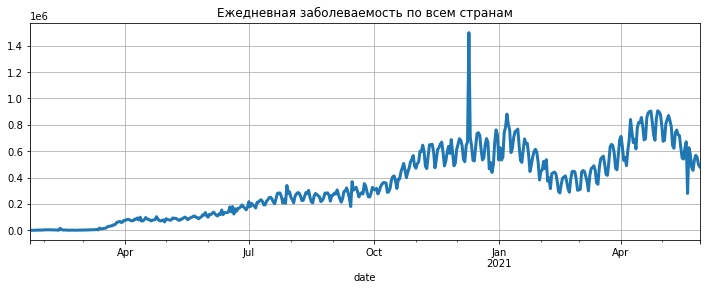

In [31]:
grouped_cases = covid_df.groupby('date')['daily_confirmed'].sum()
grouped_cases.plot(
    kind = 'line',
    figsize = (12 ,4),
    title = 'Ежедневная заболеваемость по всем странам',
    grid = True,
    lw = 3
)

<AxesSubplot:title={'center':'Распределение ежедневной заболеваемости'}, ylabel='Frequency'>

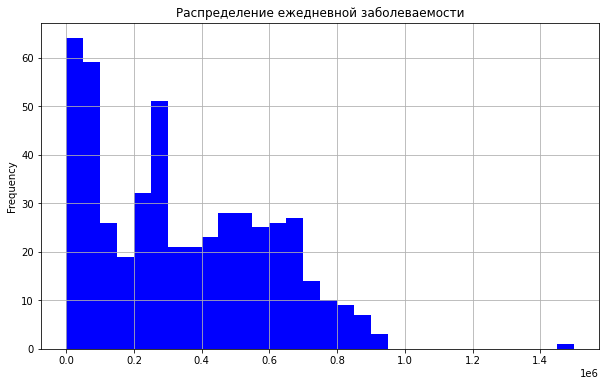

In [34]:
grouped_cases.plot(
    kind = 'hist',
    figsize = (10, 6),
    title = 'Распределение ежедневной заболеваемости',
    grid = True,
    color = 'blue',
    bins = 30
)

Давайте построим столбчатую диаграмму, которая покажет ТОП-10 стран по суммарной заболеваемости.

Для этого сгруппируем данные по странам и вычислим последний зафиксированный показатель с помощью агрегирующего метода last() — он возвращает последнее значение в столбце DataFrame.

Для построения столбчатой диаграммы значение параметра kind выставляем на 'bar'. Параметр colormap отвечает за цветовую гамму графика.

<AxesSubplot:xlabel='country'>

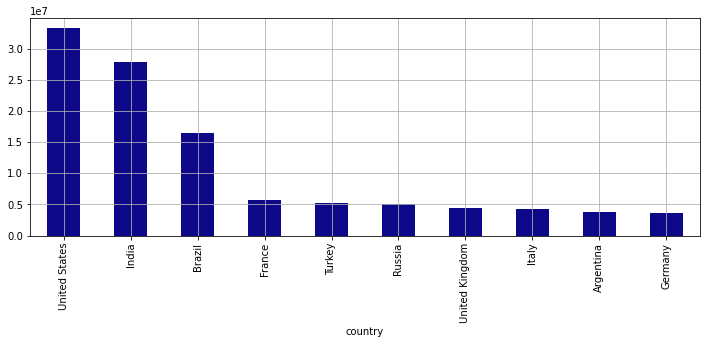

In [35]:
grouped_country = covid_df.groupby(['country'])['confirmed'].last()
grouped_country = grouped_country.nlargest(10)
grouped_country.plot(
    kind='bar',
    grid=True,
    figsize=(12, 4),
    colormap='plasma'
)

На диаграмме видно, что лидерами по числу заболевших являются Соединённые Штаты, Индия и Бразилия. Соотношение зафиксированных случаев заражения в остальных странах примерно одинаковое.

А теперь посмотрим, как в этих десяти странах соотносится количество заболевших и умерших от вируса. Для этого отобразим сразу два показателя на столбчатой диаграмме: 

<AxesSubplot:xlabel='country'>

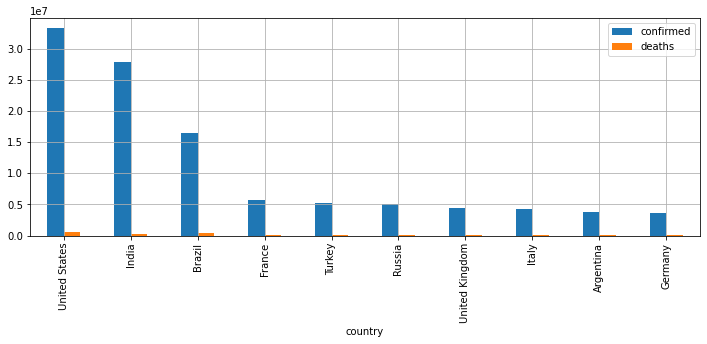

In [36]:
grouped_country = covid_df.groupby(['country'])[['confirmed', 'deaths']].last()
grouped_country = grouped_country.nlargest(10, columns=['confirmed'])
grouped_country.plot( 
    kind='bar', 
    grid=True, 
    figsize=(12, 4), 
)

<AxesSubplot:xlabel='country'>

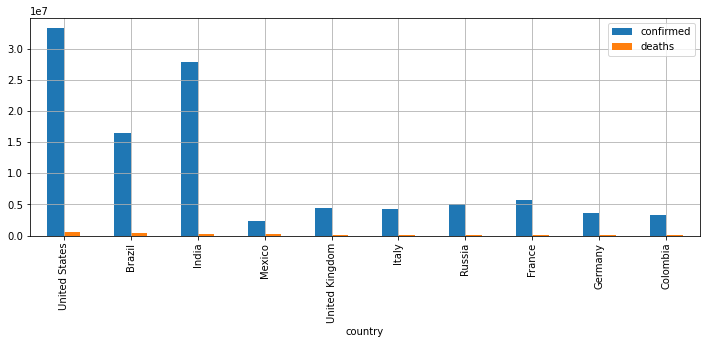

In [37]:
grouped_country = covid_df.groupby(['country'])[['confirmed', 'deaths']].last()
grouped_country = grouped_country.nlargest(10, columns=['deaths'])
grouped_country.plot( 
    kind='bar', 
    grid=True, 
    figsize=(12, 4), 
)

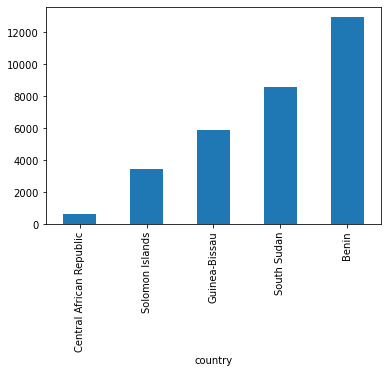

In [38]:
covid_df.groupby(['country'])['total_vaccinations'].last().nsmallest(5).plot(kind='bar');

# 5. Графические возможности библиотеки Matplotlib

За визуализацию графиков в Matplotlib отвечает модуль pyplot. Традиционно он импортируется под псевдонимом plt. Для более корректного отображения графиков в ноутбуках используется команда %matplotlib inline.

## Основные параметры метода scatter()

x, y — последовательности, которые будут отложены по осям абсцисс и ординат;
s — размер маркеров;
marker — вид маркеров ('o' — точки, '^' — треугольники);
c — цвет маркеров.

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')

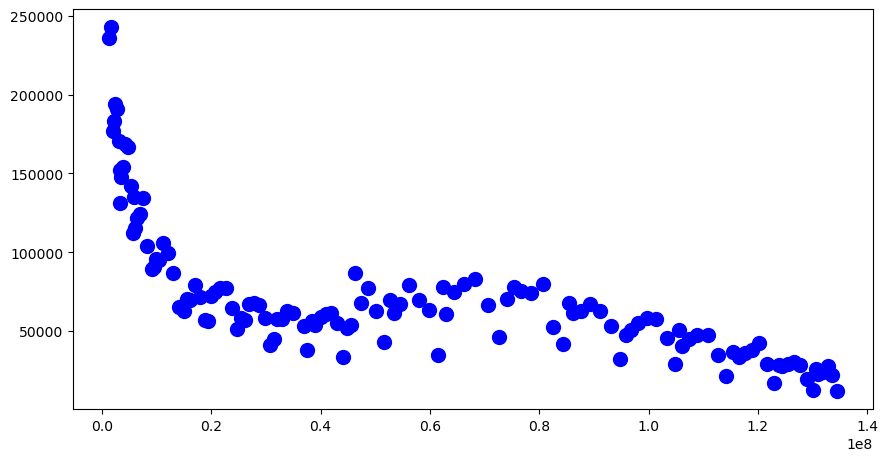

In [43]:
us_data = covid_df[covid_df['country'] == 'United States']
# Поле 8*4 дюйма
fig = plt.figure(figsize=(8, 4))
# Система координат, от нуля, на всё поле (100% = 1)
axes = fig.add_axes([0, 0, 1, 1])
# На диаграмме рассеяния по оси абсцисс откладываем суммарное число поставленных вакцин, 
# а по оси ординат — ежедневный прирост заболевших:
axes.scatter(
    x=us_data['people_fully_vaccinated'], 
    y=us_data['daily_confirmed'], 
    s=100,
    marker='o',
    c = 'blue'
);

## Основные параметры метода pie()

x — значения, по которым будет строиться круговая диаграмма;
labels — метки, соответствующие значениям;
autopct — формат отображения долей на диаграмме (например, '%.1f%%' означает, что округление будет производиться до первого знака после запятой и при выводе будет указан знак "%"; открывающий и закрывающий проценты означают форматирование, а внутренний — вывод знака "%");
explode — последовательность, которая определяет долю смещения сектора от центра для каждого значения из x.

Построим круговую диаграмму, чтобы отобразить ТОП-10 комбинаций вакцин в мире.

Примечание. Обратите внимание, что под «распространённостью» вакцины здесь подразумевается не количество введённых доз (таких данных у нас в таблице нет), а количество стран, в которых она используется. При этом подсчёт ведётся не по каждой отдельной вакцине, а по их комбинациям, и одна и та же вакцина учитывается несколько раз в сочетаниях с другими.

ТОП-10 комбинаций вакцин (vaccines) по распространённости мы находим с помощью метода value_counts(). Круговую диаграмму строим на полученных значениях, метки для каждого значения — индексы промежуточной таблицы. Будем отображать доли в процентах и округлять их до одного знака после запятой. Самую распространённую вакцину сместим на 10 % от центра:

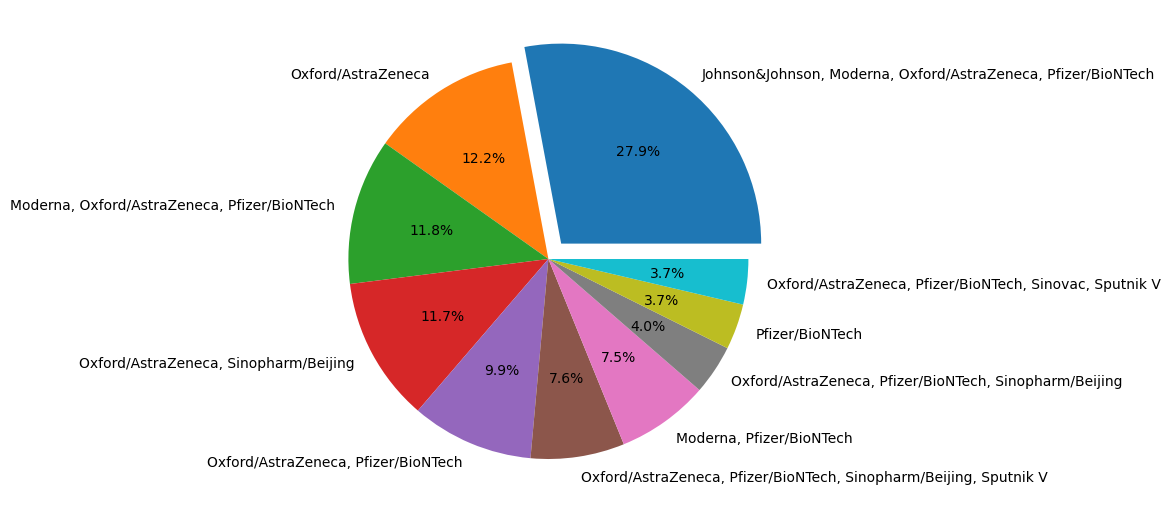

In [49]:
vaccine_combinations = covid_df['vaccines'].value_counts()[:10]
fig = plt.figure(figsize=(5, 5))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    vaccine_combinations,
    labels=vaccine_combinations.index,
    autopct='%.1f%%',
    explode = [0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
);

Обратите внимание, что диаграмма показывает соотношение только для десяти популярных комбинаций вакцин, а не для всех вакцин в совокупности, что является не совсем корректным для круговой диаграммы, так как она должна отображать единое целое.

К тому же наша круговая диаграмма считает количество использований каждой комбинации в таблице, а не количество стран, в которых используется эта комбинация, что также является некорректным.

→ Более правильным вариантом в данном случае было бы выделить каждую вакцину в отдельности и посчитать, в скольких странах она используется.

Однако для этого нам необходимо будет совершить несколько довольно сложных преобразований:

Для начала нам необходимо избавиться от пропусков в столбце с вакцинами. Сделаем это с помощью метода dropna(), который удаляет строки, содержащие пропуски в столбце, указанном в параметре subset(). Данный метод мы будем изучать в следующем модуле, посвящённом очистке данных — пока что не вам не стоит заострять на нём внимание:

combination_not_nan = covid_df.dropna(subset=['vaccines'])
Полученные данные необходимо сгруппировать по странам (country) и определить последнюю зафиксированную комбинации вакцин в столбце vaccines:

combination_last = combination_not_nan.groupby(['country'])['vaccines'].last()
В результате такого преобразования мы получаем Series, значениями которого являются комбинации вакцин, которые использовались в странах в последний день рассматриваемого периода.

display(combination_last)
img

Преобразуем данные с помощью метода apply(): применим к столбцу lambda-функцию, в которой будем удалять из строки с комбинациями вакцин пробелы и разделять комбинацию на отдельные составляющие по запятым.

combination_last = combination_last.apply(lambda x: x.replace(' ', '').split(','))
В результате в каждой строке столбца получим список с отдельными вакцинами, которые используются в стране:

img

Создадим словарь vaccines_dict={}, ключами которого будут являться уникальные вакцины, а значениями — количество стран, в которых они используются. Изначально словарь пустой.

Заполнение словаря реализуем «в лоб» — используя циклы. Во внешнем цикле будем проходиться по всем элементам Series combination_last. На каждой итерации цикла в переменной цикла vaccines_list будет находиться список вакцин, которые используются в стране.

Во внутреннем цикле будем проходиться по элементам этого списка, вакцинам. Переменную внутреннего цикла назовём vaccine.

В теле внутреннего цикла проверяем условие, что текущей вакцины ещё нет среди ключей словаря vaccones_dict. Если это условие выполняется, добавляем вакцину в словарь со значением 1. В противном случае увеличиваем текущее количество стран, в которых используется данная вакцина:

vaccines_dict = {} 
#создаём цикл по элементам Series combination_last
for vaccines_list in combination_last:
    #создаём цикл по элементам списка с вакцинами
    for vaccine in vaccines_list:
        #проверяем условие, что текущей вакцины ещё нет среди ключей словаря
        if vaccine not in vaccines_dict:#если условие выполняется
            vaccines_dict[vaccine] = 1 #заносим вакцину в словарь со значением 1
        else: #в противном случае
            vaccines_dict[vaccine] += 1 #увеличивает количество
В результате работы получаем словарь, который преобразуем в объект Series. Далее выделим семь наиболее популярных вакцин, а остальные обозначим как 'other'. Для этого сортируем Series по убыванию. Вычислим суммарное количество стран, в которых используются вакцины, не попавшие в наш ТОП-7, результат запишем в Series по индексу 'other'.

Далее выделим восемь наибольших значений в полученной Series — для них и будем строить круговую диаграмму.

vaccines = pd.Series(vaccines_dict).sort_values(ascending=False)
vaccines['other'] = vaccines[7:].sum()
vaccines = vaccines.sort_values(ascending=False)[:8]
Строим круговую диаграмму:

fig = plt.figure(figsize=(5, 5))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    vaccines,
    labels=vaccines.index,
    autopct='%.1f%%',
);

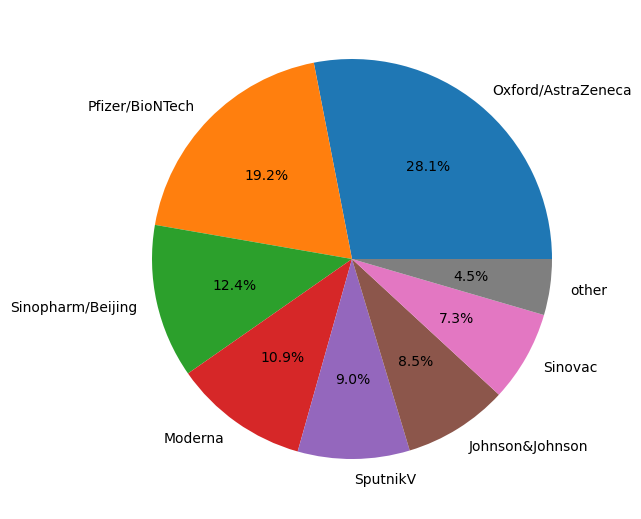

In [52]:
#избавляемся от пропусков в столбце с вакцинами
combination_not_nan = covid_df.dropna(subset=['vaccines'])
#группируем по странам и выбираем последнюю комбинацию вакцин в стране
combination_last = combination_not_nan.groupby(['country'])['vaccines'].last() 
#заменяем пробелы в строках и делим комбинации на отдельные вакцины по запятой
combination_last = combination_last.apply(lambda x: x.replace(' ', '').split(',')) 
#создаём пустой словарь, ключами которого будут вакцины, а значениями — количество стран
vaccines_dict = {} 
#создаём цикл по элементам Series combination_last
for vaccines_list in combination_last:
    #создаём цикл по элементам списка с вакцинами
    for vaccine in vaccines_list:
        #проверяем условие, что текущей вакцины ещё нет среди ключей словаря
        if vaccine not in vaccines_dict:#если условие выполняется
            vaccines_dict[vaccine] = 1 #заносим вакцину в словарь со значением 1
        else: #в противном случае
            vaccines_dict[vaccine] += 1 #увеличивает количество
#преобразуем словарь в Series
vaccines = pd.Series(vaccines_dict).sort_values(ascending=False)
#выделяем ТОП-7 вакцин и добавляем категорию 'other'
vaccines['other'] = vaccines[7:].sum()
vaccines = vaccines.sort_values(ascending=False)[:8]
#строим круговую диаграмму
fig = plt.figure(figsize=(5, 5))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    vaccines,
    labels=vaccines.index,
    autopct='%.1f%%',
);

## ДОБАВЛЕНИЕ ИНФОРМАТИВНОСТИ В ГРАФИКИ

Вы, наверное, заметили, что до этого мы не подписывали графики. График не имеет смысла, если без лишних слов непонятно, что на нём изображено. Управлять информативностью графика можно с помощью методов координатной плоскости axes. Перечислим основные из них (не пугайтесь, запоминать их не обязательно — вы всегда сможете подсмотреть их в документации):

axes.set_title() — заголовок диаграммы, а также его настройки (например, параметр fontsize отвечает за размер шрифта);
axes.set_xlabel() — название оси абсцисс;
axes.set_ylabel() — название оси ординат;
axes.set_xticks() — установка отметок на оси абсцисс;
axes.set_yticks() — установка отметок на оси ординат;
axes.xaxis.set_tick_params() — управление параметрами отметок на оси абсцисс (например, параметр rotation отвечает за поворот отметок в градусах);
axes.yaxis.set_tick_params() — управление параметрами отметок на оси ординат;
axes.legend() — отображение легенды;
axes.grid() — установка сетки.

Например, изобразим на одном графике, как росла общая заболеваемость (confirmed), число зафиксированных смертей (deaths), выздоровевших пациентов (recovered) и активных случаев (active) в Китае.

Для построения линейных графиков в Matplotlib используется метод plot() (не путайте с методом plot() в Pandas!). При вызове метода без параметров по оси абсцисс откладываются значения столбца таблицы, по оси ординат — индексы (в нашем случае это будут даты). 

Дополнительно в параметрах метода указываем параметр label — название графика, которое будет отображаться на легенде, а также lw — ширину линии графика. Добавим к графику заголовок, названия осей, установим метки по оси y с частотой в 10 000, повернём метки по оси x на 30 градусов, а также добавим легенду (метки для легенды выставляются в параметре label метода plot()):

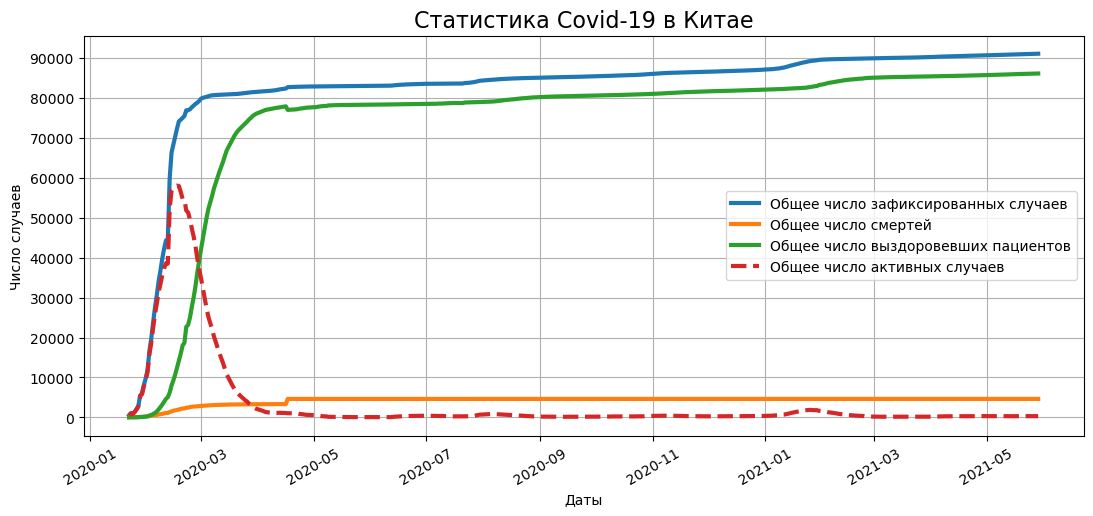

In [53]:
china_data = covid_df[covid_df['country'] == 'China']
china_grouped = china_data.groupby(['date'])[['confirmed', 'active', 'deaths', 'recovered']].sum()

#визуализация графиков
fig = plt.figure(figsize=(10, 4))
axes = fig.add_axes([0, 0, 1, 1])
axes.plot(china_grouped['confirmed'], label='Общее число зафиксированных случаев', lw=3)
axes.plot(china_grouped['deaths'], label='Общее число смертей', lw=3)
axes.plot(china_grouped['recovered'], label='Общее число выздоровевших пациентов', lw=3)
axes.plot(china_grouped['active'], label='Общее число активных случаев', lw=3, linestyle='dashed')

#установка параметров отображения
axes.set_title('Статистика Covid-19 в Китае', fontsize=16)
axes.set_xlabel('Даты')
axes.set_ylabel('Число случаев')
axes.set_yticks(range(0, 100000, 10000))
axes.xaxis.set_tick_params(rotation=30)
axes.grid()
axes.legend();

## ИСПОЛЬЗОВАНИЕ НЕСКОЛЬКИХ СИСТЕМ КООРДИНАТ

При использовании библиотеки Matplotlib вовсе не обязательно ограничиваться одной системой координат.

→ Вы можете размещать несколько систем координат на одной фигуре, что позволит нам отображать вспомогательную информацию на основном графике.

Для добавления второй системы координат необходимо повторно применить к объекту fig метод add_axes, указав новое имя для второй системы координат.

Например, отобразим ТОП-5 стран по общему числу привитых вторым компонентом людей (people_fully_vaccinated), а также ТОП-5 стран по числу полностью привитых на 100 человек населения (people_fully_vaccinated_per_hundred).

Группируем таблицу по странам, находим последний по дате зафиксированный показатель с помощью метода last() и выбираем ТОП-5 стран с использованием метода nlargest().

При отображении графиков создаём две координатные плоскости main_axes и insert_axes, на каждой из них отдельно строим столбчатые диаграммы.

### Основные параметры метода bar()

x — названия категорий, которые будут располагаться по оси абсцисс;
height — высота столбцов диаграммы, массив из показателей для визуализации (например, среднее, максимальное значение и т. д.);
width — ширина столбцов диаграммы;
color — цвет.

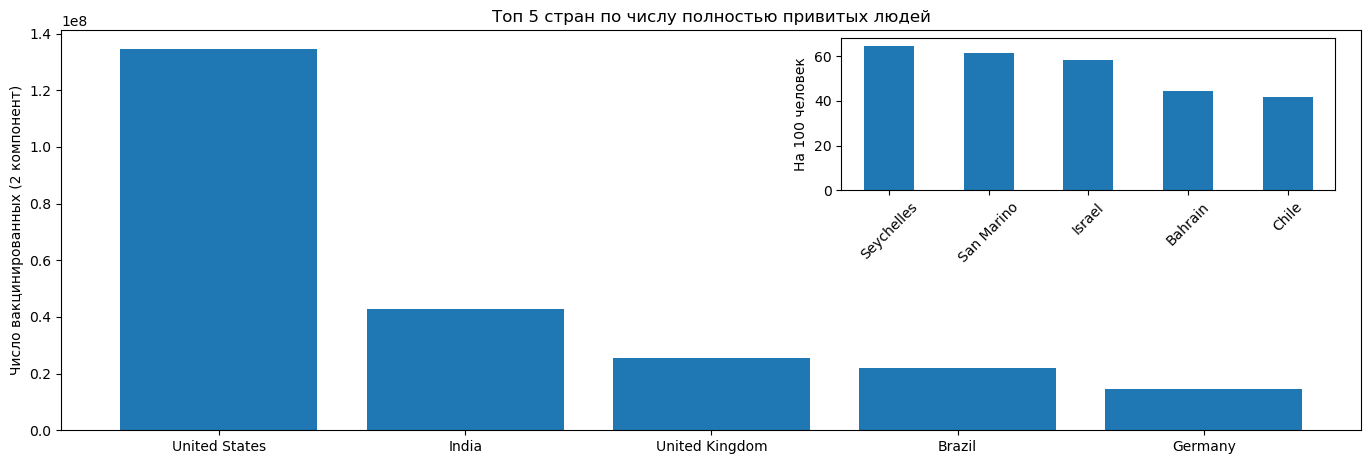

In [54]:
vacc_country = covid_df.groupby('country')['people_fully_vaccinated'].last().nlargest(5)
vacc_country_per_hundred = covid_df.groupby('country')['people_fully_vaccinated_per_hundred'].last().nlargest(5)

#визуализация главного графика
fig = plt.figure(figsize=(13, 4))
main_axes = fig.add_axes([0, 0, 1, 1])
main_axes.bar(x = vacc_country.index, height = vacc_country);
main_axes.set_ylabel('Число вакцинированных (2 компонент)')
main_axes.set_title('Топ 5 стран по числу полностью привитых людей')

#визуализация вспомогательного графика
insert_axes = fig.add_axes([0.6, 0.6, 0.38, 0.38])
# Примечание. Первые два числовых параметра, указанные при создании систем координат, — 
# это отступ снизу и слева, следующие два — ширина и высота относительно ширины и высоты 
# всего пространства (в долях единицы) для построения графика.
insert_axes.bar(x = vacc_country_per_hundred.index, height = vacc_country_per_hundred, width=0.5);
insert_axes.set_ylabel('На 100 человек')
insert_axes.xaxis.set_tick_params(rotation=45)

## SUBPLOTS

Создание дополнительных систем координат с помощью метода add_axes() полезно, однако используется не так часто.

В большинстве случаев для отображения нескольких систем координат используется функция subplots(). Она создаёт целую таблицу из систем координат на одной фигуре. Функция возвращает новую фигуру, а также список координатных плоскостей.

Кликните на плашку, чтобы увидеть информацию ↓

Основные параметры метода subplots()

nrows — число строк;
ncols — число столбцов;
figsize — общий размер фигуры в дюймах (ширина и высота).
Например, следующий код создаст шесть координатных плоскостей, сведённых в таблицу размера 2x3:

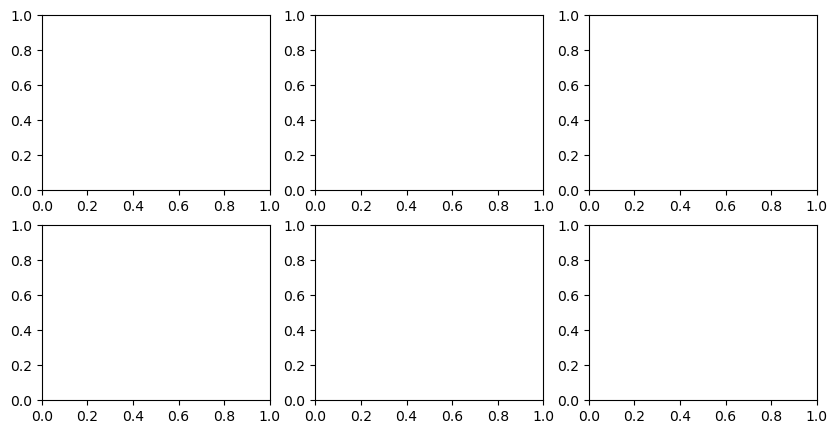

In [55]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 5))

За построение гистограмм в библиотеке Matplotlib отвечает метод hist().

Основные параметры метода hist()

x — массив чисел, для которого строится гистограмма;
bins — число столбцов (корзин);
orientation — ориентация гистограммы (по умолчанию 'vertical');
color — цвет.

Для того чтобы отобразить график в соответствующей координатной плоскости, нужно обратиться к списку axes по индексу (от 0 до 2). Дальнейшая настройка графиков вам уже известна.

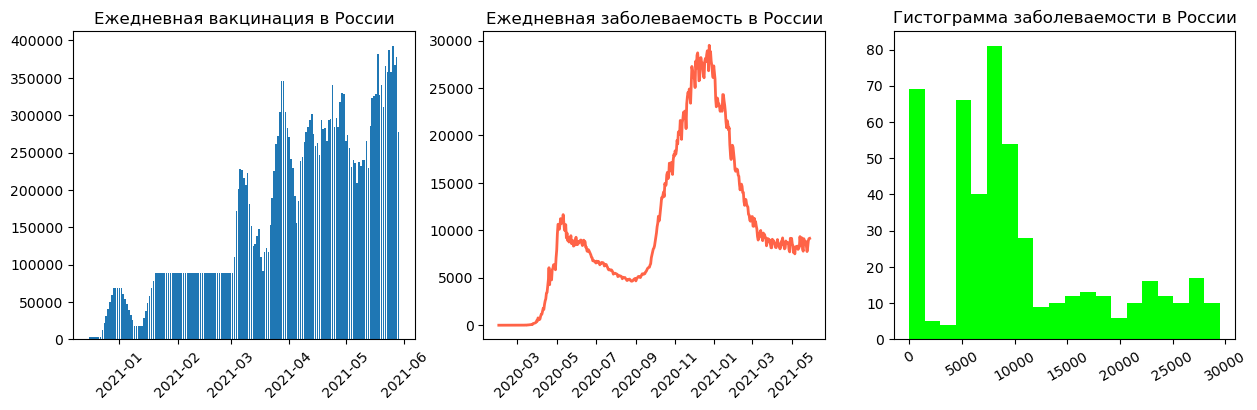

In [56]:
russia_data = covid_df[covid_df["country"] == "Russia"]

# визуализация систем координат
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

# столбчатая диаграмма
axes[0].bar(
    x=russia_data["date"],
    height=russia_data["daily_vaccinations"],
    label="Число вакцинированных",
)
axes[0].set_title("Ежедневная вакцинация в России")
axes[0].xaxis.set_tick_params(rotation=45)

# линейный график
axes[1].plot(
    russia_data["date"],
    russia_data["daily_confirmed"],
    label="Число заболевших",
    color="tomato",
    lw=2,
)
axes[1].set_title("Ежедневная заболеваемость в России")
axes[1].xaxis.set_tick_params(rotation=45)

# гистограмма
axes[2].hist(
    x=russia_data["daily_confirmed"], label=["Число заболевших"], color="lime", bins=20
)
axes[2].set_title("Гистограмма заболеваемости в России")
axes[2].xaxis.set_tick_params(rotation=30)

# 6. Графические возможности библиотеки Seaborn

In [57]:
import seaborn as sns
print(sns.__version__)

0.11.2


В данном разделе мы будем сравнивать несколько стран: Россию, Австралию, Германию, Канаду и Великобританию. Создадим специальный DataFrame croped_covid_df для этих данных.

Для фильтрации по списку значений используем метод isin(), который проверяет, есть ли запись в столбце в переданном в метод списке. В результате возвращается привычная нам маска.

⭐ А теперь снова немного магии Feature Engineering, чтобы показатели по странам стали сопоставимыми: добавим информацию о населении стран, чтобы рассчитать ежедневную заболеваемость на 100 человек — заболеваемость в процентах от общего количества населения (daily_confirmed_per_hundred).

In [58]:
countries = ['Russia', 'Australia', 'Germany', 'Canada', 'United Kingdom']
croped_covid_df = covid_df[covid_df['country'].isin(countries)]

populations = pd.DataFrame([
    ['Canada', 37664517],
    ['Germany', 83721496],
    ['Russia', 145975300],
    ['Australia', 25726900],
    ['United Kingdom', 67802690]
    ],
    columns=['country', 'population']
)
croped_covid_df = croped_covid_df.merge(populations, on=['country'])
croped_covid_df['daily_confirmed_per_hundred'] = croped_covid_df['daily_confirmed'] / croped_covid_df['population'] * 100
croped_covid_df.head()

,date,country,confirmed,deaths,recovered,active,daily_confirmed,daily_deaths,daily_recovered,total_vaccinations,people_vaccinated,people_vaccinated_per_hundred,people_fully_vaccinated,people_fully_vaccinated_per_hundred,daily_vaccinations,vaccines,death_rate,recover_rate,population,daily_confirmed_per_hundred
0,2020-01-23,Australia,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25726900,NaN
1,2020-01-25,Australia,4.0,0.0,0.0,4.0,4.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,25726900,0.000016
2,2020-01-26,Australia,4.0,0.0,0.0,4.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,25726900,0.000000
3,2020-01-27,Australia,5.0,0.0,0.0,5.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,25726900,0.000004
4,2020-01-28,Australia,5.0,0.0,0.0,5.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,25726900,0.000000


Начнём с гистограммы. Для визуализации гистограмм в библиотеке Seaborn используется метод histplot().

У данного метода (как и у всех методов библиотеки Seaborn) огромнейшее количество параметров. Мы приведём лишь основные.

## Основные параметры метода histplot()

data — DataFrame, по которому строится график;
x — признак, который будет отложен по оси абсцисс;
y — признак, который будет отложен по оси ординат;
hue — группировочный категориальный признак, который позволяет строить отдельный график для каждой категории (не стоит использовать его для гистограмм, но он широко используется для других видов графиков в Seaborn);
ax — система координат Matplotlib, в которой строится график;
color — цвет графика;
bins — число столбцов в гистограмме (по умолчанию вычисляется автоматически с помощью специальных формул);
kde — параметр, указывающий, стоит ли сглаживать гистограмму кривой (по умолчанию False).

Построим сразу две гистограммы: одна будет иллюстрировать общее распределение ежедневной заболеваемости (daily_confirmed), а вторая — то же распределение в разрезе стран. 

Для этого создаём две координатные плоскости с помощью метода subplots(). 

На первой координатной плоскости рисуем простую гистограмму с 25 столбцами, а также добавим на неё сглаживающую кривую. 

На второй гистограмме добавляем параметр названия страны по оси y. В таком случае количество наблюдений будет обозначаться на диаграмме яркостью цвета (чем темнее полоса, тем больше наблюдений находится в интервале).

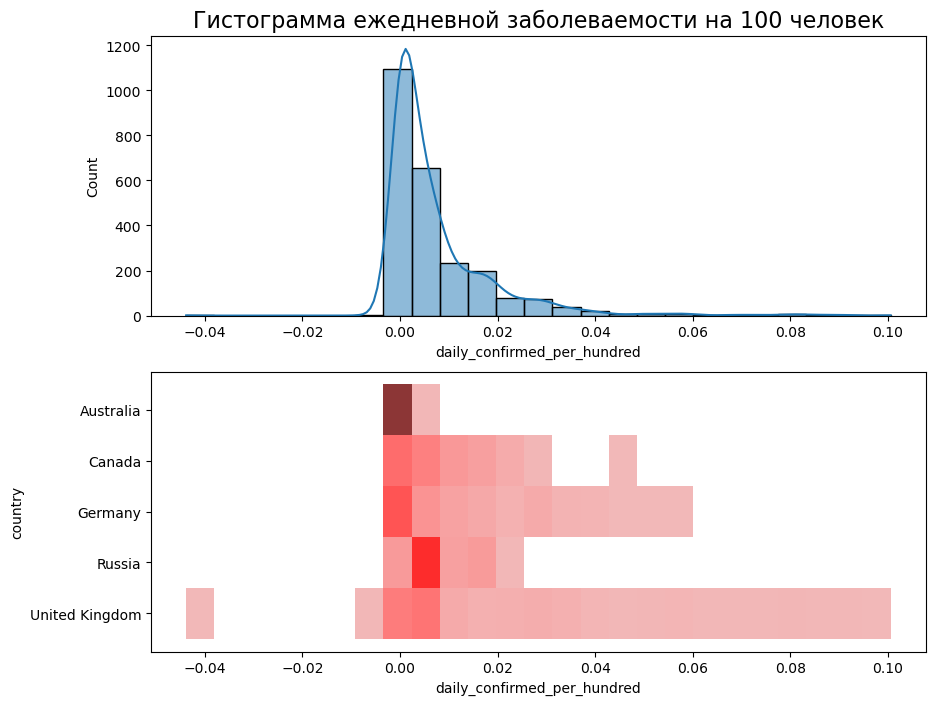

In [65]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
sns.histplot(
    data=croped_covid_df,
    x='daily_confirmed_per_hundred',
    bins=25,
    kde=True,
    ax=axes[0]
);
axes[0].set_title('Гистограмма ежедневной заболеваемости на 100 человек', fontsize=16)
sns.histplot(
    data=croped_covid_df,
    x='daily_confirmed_per_hundred',
    y='country',
    bins=25,
    color='red',
    ax=axes[1]
);

На самом деле при использовании Seaborn необязательно передавать координатные плоскости в аргументы функций. Графики в библиотеке вполне себе самодостаточны: функции для построения графика возвращают объект Axes из библиотеки Matplotlib, с которыми мы уже умеем работать. Достаточно просто занести результат выполнения функции в переменную и использовать её для настройки графика.

Рассмотрим пример — построим коробчатые диаграммы признака летальности (death_rate), который вы создавали ранее в задании 3.3.

Коробчатые диаграммы в Seaborn строятся с помощью метода boxplot().

Ящики отразим горизонтально (для этого по оси x отложим признак летальности, а по оси y — страны), параметр orient отвечает за ориентацию диаграммы, а width — за ширину коробок:



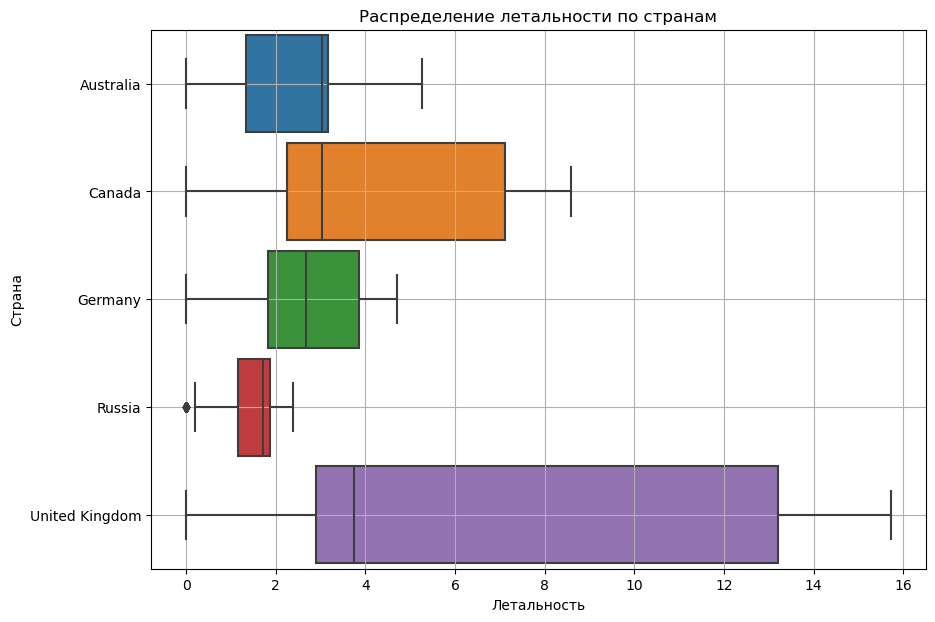

In [60]:
fig = plt.figure(figsize=(10, 7))
boxplot = sns.boxplot(
    data=croped_covid_df,
    y='country',
    x='death_rate',
    orient='h',
    width=0.9
)
boxplot.set_title('Распределение летальности по странам');
boxplot.set_xlabel('Летальность');
boxplot.set_ylabel('Страна');
boxplot.grid()

Теперь рассмотрим пример многоуровневой столбчатой диаграммы. С помощью неё мы можем, например, посмотреть на средний ежедневный процент заболевших в странах по кварталам.

Для построения столбчатых диаграмм в Seaborn используется метод barplot(). По умолчанию метод отображает среднее по столбцу, который указан в параметре x (вместо среднего можно вычислить и любую другую статистическую характеристику, наименование которой задаётся в параметре estimator). Для добавления многоуровневости используется параметр hue, который позволяет группировать данные по признаку:

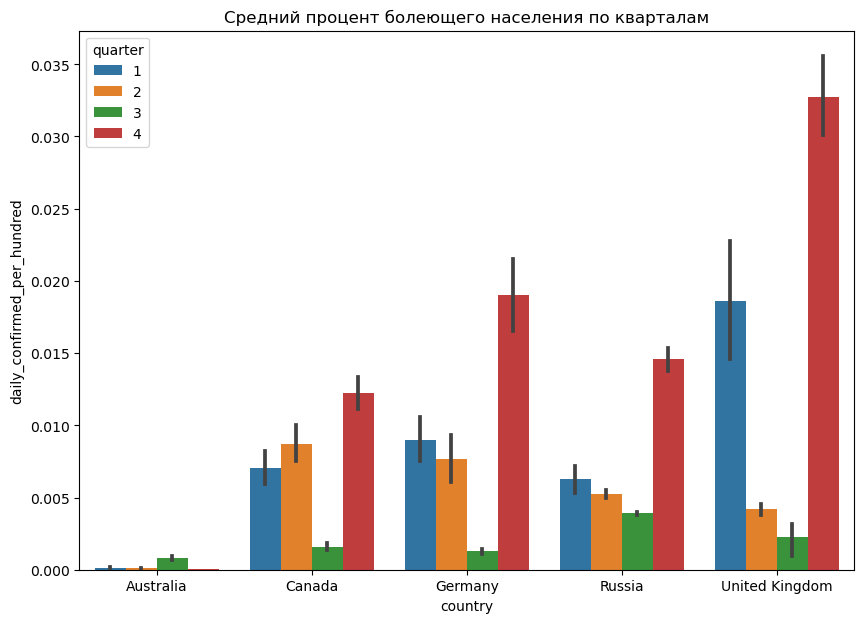

In [61]:
fig = plt.figure(figsize=(10, 7))
croped_covid_df['quarter'] = croped_covid_df['date'].dt.quarter
barplot = sns.barplot(
    data=croped_covid_df,
    x='country',
    y='daily_confirmed_per_hundred',
    hue='quarter',
)
barplot.set_title('Средний процент болеющего населения по кварталам');

Построим один из самых любимых дата-сайентистами графиков — jointplot() — в котором совмещены диаграмма рассеяния и гистограмма. Это довольно удобный и полезный инструмент, когда мы хотим одновременно посмотреть и на распределения переменных, и сразу оценить их взаимосвязь.

Построим jointplot зависимости ежедневной заболеваемости в странах от общей численности населения в процентах (daily_confirmed_per_hundred) от числа полностью вакцинированных в процентах (people_fully_vaccinated_per_hundred).

Параметры xlim и ylim определяют диапазон отображения осей x и y. Параметр height отвечает за высоту и ширину графика (он квадратный).

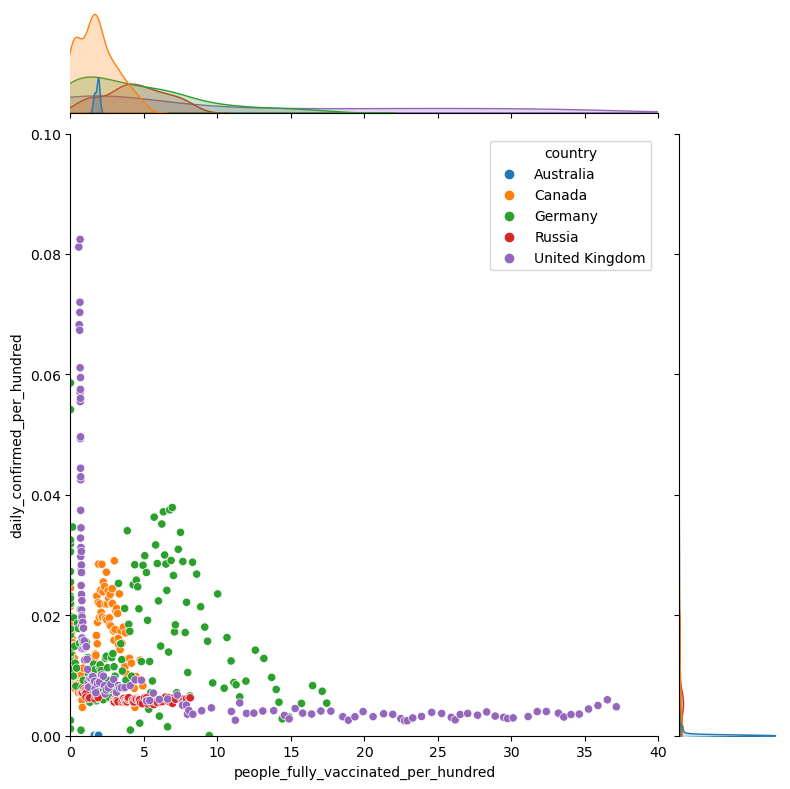

In [63]:
jointplot = sns.jointplot(
    data=croped_covid_df, 
    x='people_fully_vaccinated_per_hundred', 
    y='daily_confirmed_per_hundred',
    hue='country',
    xlim = (0, 40),
    ylim = (0, 0.1),
    height=8,
)

Допустим, мы хотим сравнить темпы вакцинации по странам во времени. Вы, скорее всего, сразу подумали о линейном графике. Но давайте мыслить шире. Когда мы хотим сравнить скорость изменения показателей по малому количеству категорий (в данном случае — по странам, а их у нас их всего пять), нагляднее всего будет тепловая карта.

Предварительно создадим сводную таблицу: по столбцам отложим признак даты, а по строкам — страны. В ячейках таблицы будет находиться процент вакцинированных (первым компонентом) людей в стране на определённую дату. Чтобы даты отображались на тепловой карте верно, их необходимо привести к типу string.

In [66]:
pivot = croped_covid_df.pivot_table(
    values='people_vaccinated_per_hundred',
    columns='date',
    index='country',
)
pivot.columns = pivot.columns.astype('string')
display(pivot)

date,2020-12-13,2020-12-14,2020-12-15,2020-12-16,2020-12-17,2020-12-18,2020-12-19,2020-12-20,2020-12-21,2020-12-22,...,2021-05-20,2021-05-21,2021-05-22,2021-05-23,2021-05-24,2021-05-25,2021-05-26,2021-05-27,2021-05-28,2021-05-29
country,,,,,,,,,,,,,,,,,,,,,
Australia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,12.40,12.69,12.88,13.28,13.73,14.18
Canada,NaN,0.0,0.00,0.01,0.02,0.03,0.03,0.03,0.05,0.07,...,48.10,49.25,50.14,50.89,51.77,52.39,53.05,53.95,54.99,55.71
Germany,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,39.18,39.68,39.95,40.11,40.29,40.64,41.29,41.87,42.40,42.61
Russia,NaN,NaN,0.02,NaN,NaN,NaN,NaN,NaN,NaN,0.04,...,10.20,10.30,10.50,10.53,10.70,10.81,11.07,11.12,11.19,11.29
United Kingdom,0.13,NaN,NaN,NaN,NaN,NaN,NaN,0.99,NaN,NaN,...,55.01,55.33,55.63,55.82,55.99,56.27,56.61,56.99,57.29,57.56


Для построения тепловой карты в Seaborn используется метод heatmap(). Данный метод работает с табличными данными и визуализирует все ячейки таблицы с помощью цвета. Параметр annot отвечает за отображение легенды (аннотации), параметр cmap — за цветовую гамму графика.

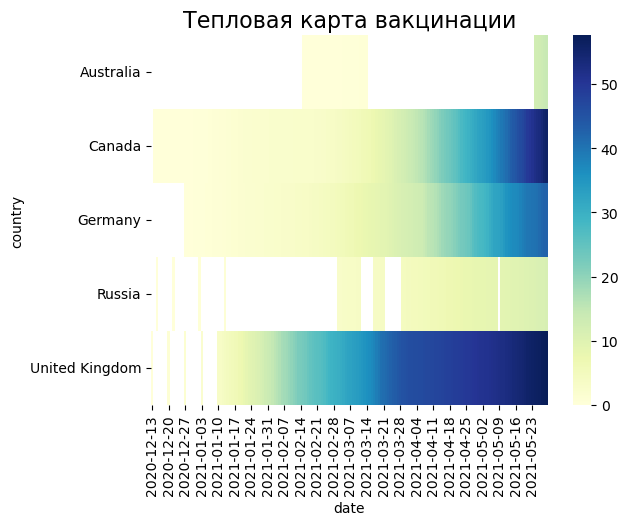

In [67]:
heatmap = sns.heatmap(data=pivot, cmap='YlGnBu')
heatmap.set_title('Тепловая карта вакцинации', fontsize=16);

### Задание 6.4
Создайте новый признак confirmed_per_hundred, который покажет процентное отношение заболевших вирусом к общему числу населения в странах ().
Постройте тепловую карту, которая покажет, как росло число заболевших в процентах от общего числа населения (confirmed_per_hundred) в странах из таблицы croped_covid_df.
Выберите верные выводы по построенному графику:
A Из представленных стран самые быстрые темпы роста относительной заболеваемости — в Великобритании.
B Суммарное число заболевших в Австралии превышает 2 % от общего числа населения.
C Интенсивность относительной заболеваемости в России выше, чем в Германии.
D Из представленных стран самая низкая скорость распространения вируса — в Австралии.

In [72]:
croped_covid_df['confirmed_per_hundred'] = (croped_covid_df['confirmed']/croped_covid_df['population'])*100

pivot2 = croped_covid_df.pivot_table(
    values='confirmed_per_hundred',
    columns='date',
    index='country',
)
pivot2.columns = pivot.columns.astype('string')
display(pivot2)


date,2020-01-23,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,...,2021-05-20,2021-05-21,2021-05-22,2021-05-23,2021-05-24,2021-05-25,2021-05-26,2021-05-27,2021-05-28,2021-05-29
country,,,,,,,,,,,,,,,,,,,,,
Australia,0.0,0.000016,0.000016,0.000019,0.000019,0.000019,0.000035,0.000035,0.000047,0.000047,...,0.116606,0.116621,0.116637,0.116683,0.116722,0.116788,0.116854,0.116897,0.116932,0.116983
Canada,NaN,NaN,0.000003,0.000003,0.000005,0.000005,0.000008,0.000008,0.000011,0.000011,...,3.599497,3.611526,3.620169,3.628017,3.632706,3.642529,3.648718,3.661252,3.669520,3.675536
Germany,NaN,NaN,NaN,NaN,0.000005,0.000005,0.000005,0.000006,0.000010,0.000012,...,4.345962,4.355632,4.363299,4.368845,4.371625,4.374704,4.380047,4.388347,4.395716,4.401106
Russia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000001,0.000001,0.000001,...,3.368999,3.375035,3.380916,3.386963,3.392637,3.397954,3.403604,3.409708,3.415960,3.422232
United Kingdom,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000003,0.000003,0.000003,...,6.594230,6.598223,6.601946,6.605033,6.608528,6.612093,6.616504,6.621495,6.627439,6.632219


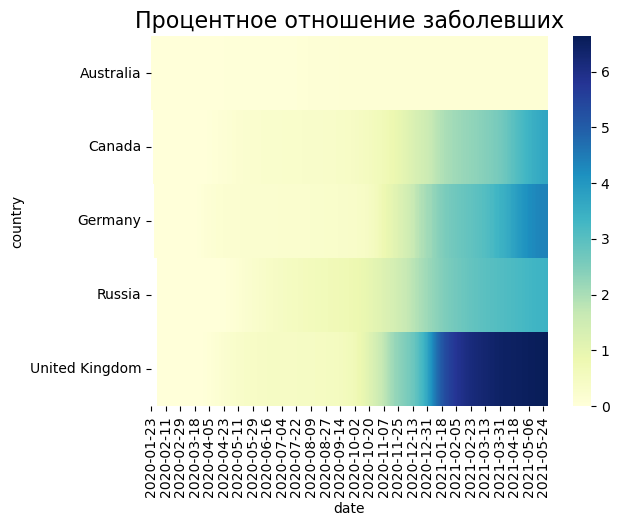

In [74]:
heatmap2 = sns.heatmap(data=pivot2, cmap='YlGnBu')
heatmap2.set_title('Процентное отношение заболевших', fontsize=16);

### Задание 6.5
Постройте коробчатую диаграмму для признака recover_rate (отношение выздоровлений к числу зафиксированных случаев заболевания в процентах).
Выберите верные выводы по данному графику:
A График для Великобритании имеет «сплюснутый» в нуле вид, что указывает либо на практически полное отсутствие случаев выздоровления, либо, с точки зрения здравого смысла, на неверные данные о числе выздоровевших пациентов в этой стране.
B Наибольший разброс по проценту ежедневных выздоровлений — в Канаде.
C Наименьшая медиана — у Германии.
D В четырёх из пяти стран на графике медианный процент ежедневных выздоровлений превышает 80 %.

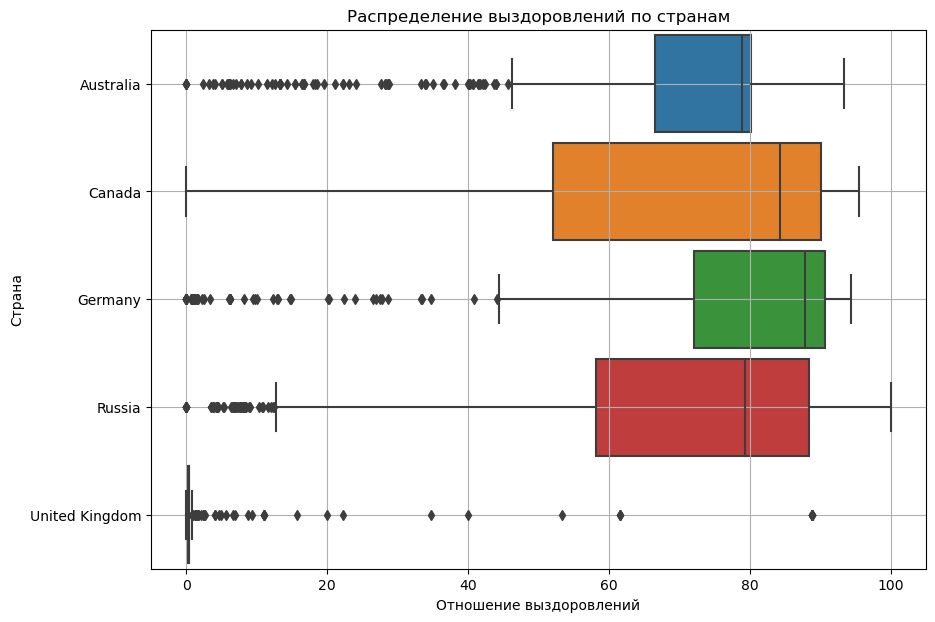

In [75]:
fig2 = plt.figure(figsize=(10, 7))
boxplot = sns.boxplot(
    data=croped_covid_df,
    y='country',
    x='recover_rate',
    orient='h',
    width=0.9
)
boxplot.set_title('Распределение выздоровлений по странам');
boxplot.set_xlabel('Отношение выздоровлений');
boxplot.set_ylabel('Страна');
boxplot.grid()

# 7. Графические возможности библиотеки Plotly

ЭКСПРЕСС-РЕЖИМ

Plotly позволяет строить графики в нескольких режимах. Мы рассмотрим самый новый и подающий надежды — экспресс-режим. Его функциональность скромнее, чем у полного режима Plotly, но нам её будет более чем достаточно. Для работы в экспресс-режиме предназначен модуль plotly.express. Он был выпущен в марте 2019 года и находится в процессе активной разработки.

→ Работа с plotly.express напоминает работу с библиотекой Seaborn. Отличие лишь в том, что все настройки графика (размеры, подписи осей, текста на графике) прописываются в самом методе.

С помощью экспресс-режима (px) можно строить уже знакомые нам графики:

line() — линейные графики;
histogram() — гистограммы;
scatter() — диаграммы рассеяния;
box() — коробчатые диаграммы;
bar() — столбчатые диаграммы;
pie() — круговые диаграммы.
Также есть множество других графиков — их список вы можете посмотреть в документации (https://plotly.com/python/).

In [76]:
import plotly
import plotly.express as px
print(plotly.__version__)

5.7.0


Основные параметры метода line()

data_frame — DataFrame, по которому строится график;
x — признак по оси абсцисс;
y — признак по оси ординат;
height — высота графика;
width — ширина графика;
title — название графика.

Построим график роста зафиксированного числа случаев заражения (confirmed), смертей (deaths), выздоровлений (recovered) и активных случаев (active) за всё время. Для этого просуммируем статистику по дням и передадим полученный DataFrame в метод line().

Для отображения созданной методом line() фигуры используется метод fig.show():

In [77]:
line_data = covid_df.groupby('date', as_index=False).sum()
fig = px.line(
    data_frame=line_data, #DataFrame
    x='date', #ось абсцисс
    y=['confirmed', 'recovered', 'deaths', 'active'], #ось ординат
    height=500, #высота
    width=1000, #ширина
    title='Confirmed, Recovered, Deaths, Active cases over Time' #заголовок
)
fig.show()